In [86]:
!pip install wfdb
!pip install matplotlib numpy
!pip install --upgrade wfdb
!pip install numpy==2.0.0
import os
os.environ['NPY_PROMOTION_STATE'] = 'weak_and_warn'
import numpy
numpy.__version__


^C


'2.1.2'

  Using cached numpy-2.0.0-cp312-cp312-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
    --------------------------------------- 0.3/16.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/16.2 MB 598.5 kB/s eta 0:00:27
   - -------------------------------------- 0.8/16.2 MB 762.0 kB/s eta 0:00:21
   -- ------------------------------------- 1.0/16.2 MB 882.6 kB/s eta 0:00:18
   --- ------------------------------------ 1.3/16.2 MB 958.5 kB/s eta 0:00:16
   --- ------------------------------------ 1.3/16.2 M

In [18]:
!pip install hrv-analysis

   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   - -------------------------------------- 0.3/6.4 MB ? eta -:--:--
   --- ------------------------------------ 0.5/6.4 MB 762.0 kB/s eta 0:00:08
   --- ------------------------------------ 0.5/6.4 MB 762.0 kB/s eta 0:00:08
   --- ------------------------------------ 0.5/6.4 MB 762.0 kB/s eta 0:00:08
   ---- ----------------------------------- 0.8/6.4 MB 516.0 kB/s eta 0:00:11
   ---- ----------------------------------- 0.8/6.4 MB 516.0 kB/s eta 0:00:11
   ------ --------------------------------- 1.0/6.4 MB 592.2 kB/s eta 0:00:10
   -------- ------------------------------- 1.3/6.4 MB 627.1 kB/s eta 0:00:09
   -------- ------------------------------- 1.3/6.4 MB 627.1 kB/s eta 0:00:09
   --------- ------------------------------ 1.6/6.4 MB 682.0 kB/s eta 0:00:08
   ----------- ---------------------------- 1.8/6.4 MB 734.6 kB/s eta 0:00:07
   ----------

# display original signal 

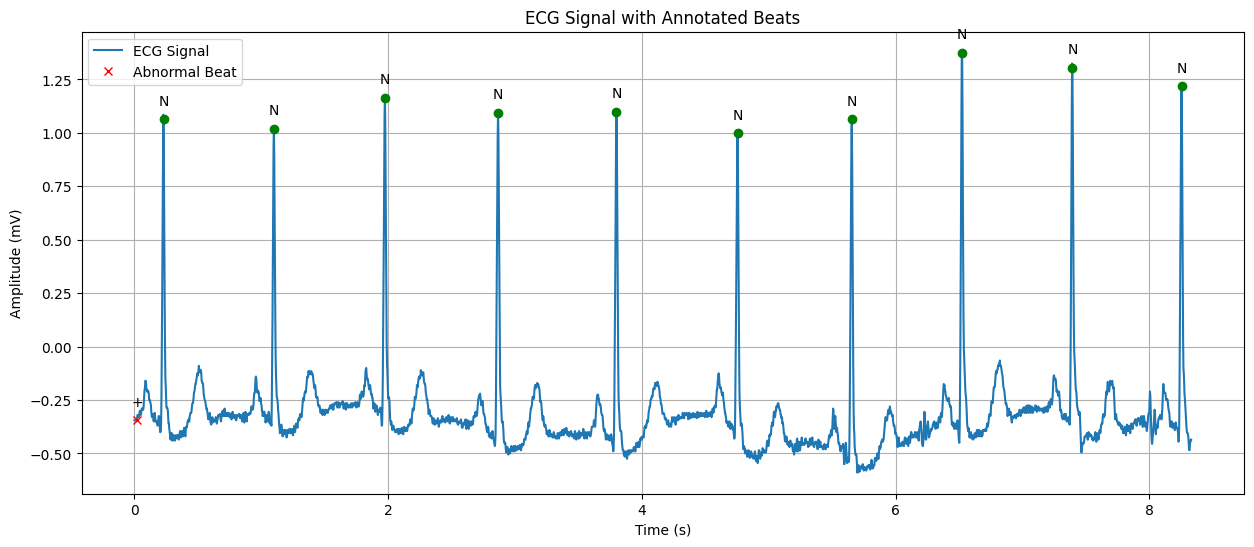

In [67]:
import wfdb
import matplotlib.pyplot as plt
import wfdb.processing

data_directory = 'mit-bih-arrhythmia-database-1.0.0/'
record_name = '101'
record = wfdb.rdrecord(f'{data_directory}{record_name}', sampto=3000)

# Read annotations
annotation = wfdb.rdann(f'{data_directory}{record_name}', 'atr')

fs = record.fs  # Sampling frequency
signal = record.p_signal[: 1000* fs, 0]  # Taking the first 5 seconds (first channel)
time = [i / fs for i in range(len(signal))]
labels = annotation.symbol  # Labels for the annotations
rpeaks = wfdb.processing.xqrs_detect(signal, fs=fs, verbose=False)

# Plot the ECG signal
plt.figure(figsize=(15, 6))
plt.plot(time, signal, label='ECG Signal')

for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < len(signal):
        if symbol == 'N':  # Normal beat
            plt.plot(sample / fs, signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample / fs, signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('Time (s)')
plt.ylabel('Amplitude (mV)')
plt.title('ECG Signal with Annotated Beats')
plt.legend(loc='best')
plt.grid()
plt.show()






# methode for filter the signal 

In [ ]:
import numpy as np
from scipy.ndimage import median_filter

def custom_filter(signal):
    # Apply the second-order low-pass filter using the given difference equation
    y = np.zeros_like(signal)
    for n in range(12, len(signal)):
        y[n] = (1/18)*y[n-1] - (1/36)*y[n-2] + (1/36)*signal[n] - (1/18)*signal[n-6] + signal[n-12]

    # Apply two median filters to remove baseline drift
    filtered_signal_1 = median_filter(y, size=72)  # 200 ms median filter
    filtered_signal_2 = median_filter(y, size=216) # 600 ms median filter
    
    # Remove baseline drift
    baseline_drift = filtered_signal_2
    cleaned_signal = y - baseline_drift
    
    return cleaned_signal


# display the signal original and the siganl after execute filter custom methode

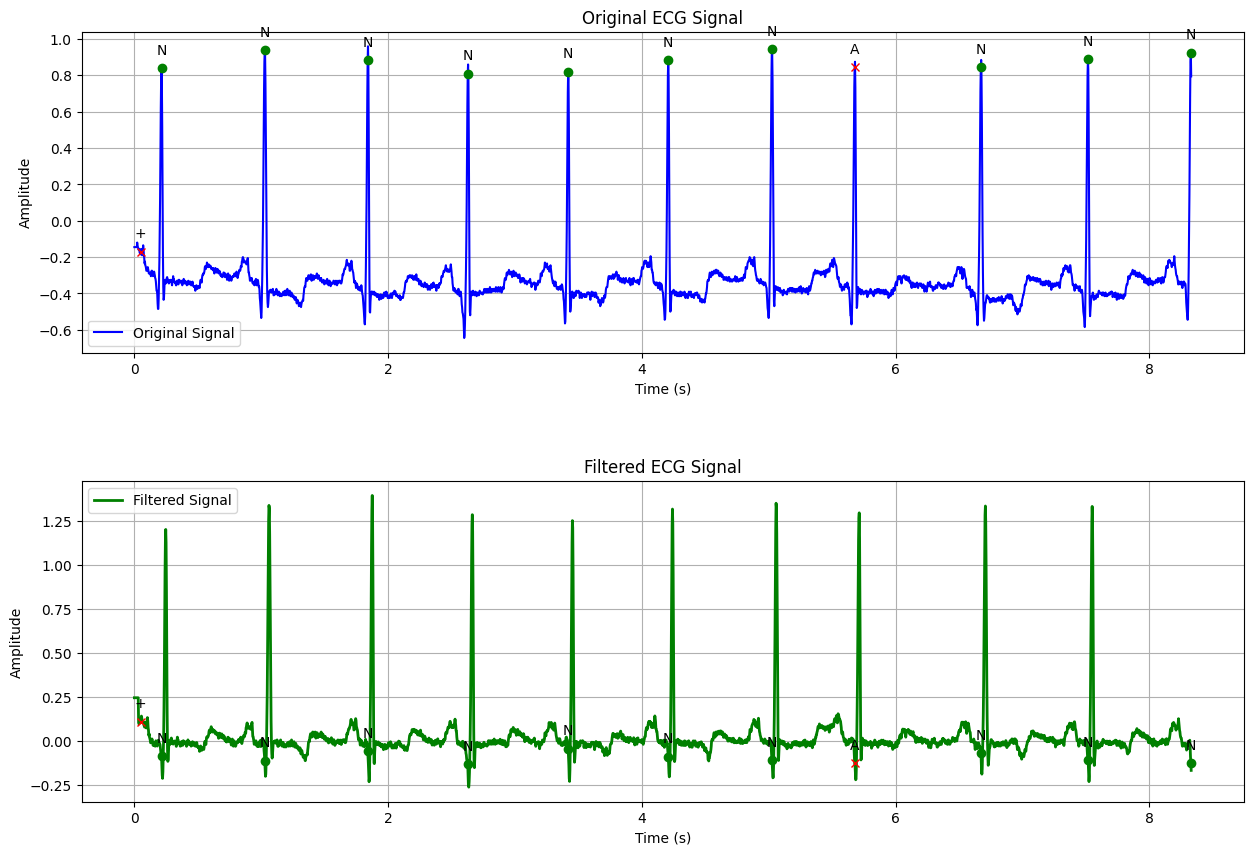

In [21]:

import numpy as np
from scipy.signal import butter, lfilter
import matplotlib.pyplot as plt

# Assume signal, fs, time, annotation, and custom_filter are defined

filtered_signal = custom_filter(signal)

plt.figure(figsize=(15, 10))

# Plot the original ECG signal
plt.subplot(2, 1, 1)
plt.plot(time, signal, 'b-', label='Original Signal')
plt.title('Original ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Annotate R-peaks on the original signal
for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < len(signal):
        if symbol == 'N':  # Normal beat
            plt.plot(sample / fs, signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample / fs, signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample / fs, signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

# Plot the filtered ECG signal
plt.subplot(2, 1, 2)
plt.plot(time, filtered_signal, 'g-', linewidth=2, label='Filtered Signal')
plt.title('Filtered ECG Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.legend()
plt.grid()

# Annotate R-peaks on the filtered signal
for i, (sample, symbol) in enumerate(zip(annotation.sample, annotation.symbol)):
    if sample < len(filtered_signal):
        if symbol == 'N':  # Normal beat
            plt.plot(sample / fs, filtered_signal[sample], 'go', label='Normal Beat' if i == 0 else "")
            plt.annotate('N', (sample / fs, filtered_signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')
        else:  # Abnormal beat (e.g., 'A', 'V', etc.)
            plt.plot(sample / fs, filtered_signal[sample], 'rx', label='Abnormal Beat' if i == 0 else "")
            plt.annotate(symbol, (sample / fs, filtered_signal[sample]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.subplots_adjust(hspace=0.4)  # Adjust the space between plots
plt.show()


# RR Interval Features

In [46]:
r_wave_indices = annotation.sample

# Calculate RR intervals
rr_intervals = np.diff(r_wave_indices)

# Previous RR interval for each R wave
previous_rr = np.concatenate(([np.nan], rr_intervals[:-1]))

# Post RR interval for each R wave
post_rr = np.concatenate((rr_intervals[1:], [np.nan]))

# Averaged RR intervals for 1-minute and 20-minute recordings
rr_1_min = np.mean(rr_intervals[:int(1 * record.fs)])  # First 1 minute
rr_20_min = np.mean(rr_intervals[:int(20 * record.fs)])  # First 20 minutes

# Display results
print(f"Previous RR intervals: {previous_rr}")
print(f"Post RR intervals: {post_rr}")
print(f"Averaged 1-minute RR interval: {rr_1_min}")
print(f"Averaged 20-minute RR interval: {rr_20_min}")

Previous RR intervals: [ nan  76. 313. ... 356. 357. 368.]
Post RR intervals: [313. 315. 321. ... 368. 379.  nan]
Averaged 1-minute RR interval: 312.5416666666667
Averaged 20-minute RR interval: 346.9001601708489


In [35]:
!pip install PyWavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   ---- ----------------------------------- 0.5/4.2 MB 1.0 MB/s eta 0:00:04
   ------- -------------------------------- 0.8/4.2 MB 1.2 MB/s eta 0:00:03
   --------- ------------------------------ 1.0/4.2 MB 1.1 MB/s eta 0:00:03
   ------------ --------------------------- 1.3/4.2 MB 1.2 MB/s eta 0:00:03
   -------------- ------------------------- 1.6/4.2 MB 1.1 MB/s eta 0:00:03
   ----------------- ---------------------- 1.8/4.2 MB 1.2 MB/s eta 0:00:03
   ------------------- -------------------- 2.1/4.2 MB 1.2 MB/s eta 0:00:02
   ---------------------- ----------------- 2.4/4.2 MB 1.2 MB/s eta 0:00:02
   ------------------------ --------------- 2.6/4.2 MB 1.2 MB/s eta 0:00:02
   --------------------------- ------------ 2.9/4.2 MB 1.2 MB/s eta 0:00:02
   ----------------------------- 

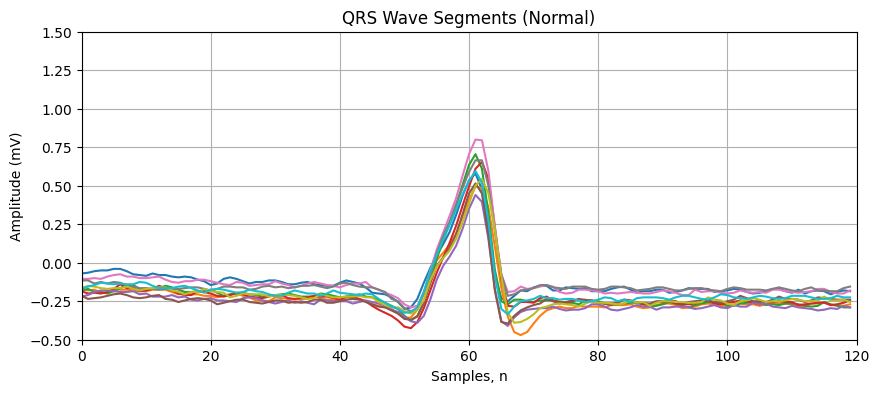

In [47]:
import numpy as np
import pywt
import matplotlib.pyplot as plt
import wfdb
from wfdb.processing import xqrs_detect

# Load your ECG data
import numpy as np
import matplotlib.pyplot as plt
import wfdb
import pywt
from wfdb.processing import xqrs_detect

data_directory = 'mit-bih-arrhythmia-database-1.0.0/'
record_name = '100'
record = wfdb.rdrecord(f'{data_directory}{record_name}', sampto=3000)

# Extract the signal and sampling frequency
fs = record.fs
signal = record.p_signal[:, 1]  # First channel

# Detect R-peaks using XQRS algorithm
rpeaks = xqrs_detect(signal, fs=fs, verbose=False)

# Define parameters for QRS segment extraction
segment_duration = 120  # Number of samples to extract around the R peak
half_segment = segment_duration // 2

# Plot the detected QRS segments
plt.figure(figsize=(10, 4))

for peak in rpeaks:
    if peak - half_segment >= 0 and peak + half_segment < len(signal):
        qrs_segment = signal[peak - half_segment: peak + half_segment]
        plt.plot(np.arange(segment_duration), qrs_segment)

# Plot formatting
plt.title('QRS Wave Segments (Normal)')
plt.xlabel('Samples, n')
plt.ylabel('Amplitude (mV)')
plt.grid()
plt.xlim(0, segment_duration)
plt.ylim(-0.5, 1.5)
plt.show()


In [41]:
!pip install astropy
